<a href="https://colab.research.google.com/github/mwvgroup/Pitt-Google-Broker/blob/u%2Ftjr%2Ftutorials/pgb_utils/tutorials/PGB_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pitt-Google Broker

# Notebook Outline

- Introduction
    - i. Data overview
    - ii. `pgb_utils` overview
    - iii. Note on costs

1. Setup

2. Databases & BigQuery
    - 2a. Python
        - Table names and schemas
        - Query lightcurves and other history
            - Plot a lightcurve
        - Cone Search
        - Using `google.cloud.bigquery` directly
    - 2b. Command-line tool `bq`

3. File Storage & Cloud Storage
    - 3a. Python
        - Download files
        - Plot cutouts and lightcurves
    - 3b. Command-line tool `gsutil`

4. Message streams and Pub/Sub

5. Extra: Apache Beam data pipelines with BigQuery and Pub/Sub
    - 5a. A demo example
    - 5b. Query lightcurves and run a pipeline on the results

---

# Introduction

## i) Data overview

All Pitt-Google Broker data is public and hosted by [Google Cloud](https://cloud.google.com/). In order to make API calls you will need to create a Cloud project that is associated with your Google account.
The Setup section of the tutorial will walk you through this.

All data and resources can be accessed via Google's [Cloud SDK](https://cloud.google.com/sdk) by way of the command-line, Python, and many other languages.
In addition, we are developing the `pgb_utils` Python package (see below) which provides convience functions for common tasks such as querying the database for lightcurves or cone searches, decoding, plotting, and processing the data.
This tutorial demonstrates access via the command-line (Cloud SDK) and Python (Cloud SDK, `pgb_utils`).

- Databases ([BigQuery](https://cloud.google.com/bigquery))
    - query for:
        - alerts (except cutouts)
        - object histories
        - cone searches

- File storage ([Cloud Storage](https://cloud.google.com/storage))
    - download the complete, original alert packets in Avro format, including cutouts (science, template, difference)

- Message streams ([Pub/Sub](https://cloud.google.com/pubsub/docs/overview))
    - streams include:
        - ZTF stream: complete
        - ZTF stream: filtered for purity
        - ZTF stream: filtered for likely extragalactic transients
        - ZTF stream + Salt2 fits (for likely extragalactic transients)

---

## ii) `pgb_utils` overview

`pgb_utils` is a collection of helper functions to facilitate interaction with Pitt-Google Broker data. The tutorial will demonstrate its use. The package is essentially a set of:

1. Convience wrappers for the [Google Cloud Python SDK](https://cloud.google.com/python/docs/reference)
2. Helper functions for ZTF data decoding and plotting, provided by ZTF (see [Filtering_alerts.ipynb](https://github.com/ZwickyTransientFacility/ztf-avro-alert/blob/master/notebooks/Filtering_alerts.ipynb))
3. Helper functions for running [Apache Beam](https://beam.apache.org/) pipelines

You are encouraged to look at and alter the source code to learn how to use the underlying methods yourself.

Modules and their functionality include:

- `pgb_utils.beam`
    - helper functions for running Apache Beam data pipelines

- `pgb_utils.bigquery`
    - view dataset, table, and schema information
    - query: lightcurves
    - query: cone search
    - cast query results to a `pandas.DataFrame` or `json` formatted string.

- `pgb_utils.figures`
    - plot lightcurves
    - plot cutouts

- `pgb_utils.utils`
    - general utilities such as data type casting


---

## iii) Note on costs

The resources used in completing this tutorial will remain well within Google Cloud's [Free Tier](https://cloud.google.com/free)(*).
If you wish to become a power-user in the future, you may need to [create a billing account](https://support.google.com/cloud/answer/6293499#enable-billing). See also: 
- [pricing structure](https://cloud.google.com/pricing) (scroll to "Only pay for what you use")
- [detailed price list](https://cloud.google.com/pricing/list) (search for "BigQuery", "Cloud Storage", "Pub/Sub"); 
- [pricing calculator](https://cloud.google.com/products/calculator?skip_cache=true) (same search as above)

(*) The Free Tier for Cloud Storage is limited to US regions. Please see that section of this tutorial for details. I am interested in feedback from users outside the US on the behavior of that section of this tutorial for them.

---

# 1) Setup


1. Use the [Cloud Resource Manager](https://console.cloud.google.com/cloud-resource-manager) to create a GCP project. Take note of the auto-generated "Project ID"; you will need it below.
    - All our data is public and hosted by [Google Cloud](https://cloud.google.com/). In order to make API calls you will need to create a Cloud project that is associated with your Google account.
    - If you work outside of Colab you may need to:
        - enable APIs for your project: [BigQuery](https://console.cloud.google.com/flows/enableapi?apiid=bigquery); 
        - [setup authentication](https://cloud.google.com/docs/authentication/getting-started)

2. Installs, imports, etc.:

In [1]:
from google.colab import auth

In [2]:
# Colab Setup
auth.authenticate_user()
# follow the instructions to authorize Google Cloud SDK 

In [3]:
my_project_id = 'my-pgb-project'  # ENTER YOUR GCP PROJECT ID HERE
pgb_project_id = 'ardent-cycling-243415'

In [4]:
# Create a function to run and print a shell command.
def run(cmd: str):
  print('>> {}'.format(cmd))
  !{cmd}
  print('')

In [ ]:
# Install some packages/versions not included with Colab
# 
packages = ['apache-beam','google-apitools','APLpy',
            'beautifulsoup4==4.8',  # plot_cutouts grayscale stretch='arcsinh'
            'astropy-healpix==0.6',  # plot_cutouts grayscale stretch='arcsinh'
            'astropy==3.2.1',  # plot_cutouts grayscale stretch='arcsinh'
            ]
# --DEBUG
# 'google-cloud-pubsub',] 
# causes:
# `ContextualVersionConflict: (PyYAML 3.13 (/usr/local/lib/python3.7/dist-packages), Requirement.parse('pyyaml>=5.2'), {'libcst'})`
# when importing apache-beam below.
# --DEBUG

for package in packages:
    run(f'pip install --quiet {package}')
# it may complain about some version conflicts but it should not cause problems.

# Note: Outside of Colab you should use `pip install apache-beam[gcp]`
# to get the Google Cloud Platform tools.

In [6]:
# Install the Pitt-Google Broker utilities package
run('python3 -m pip install --index-url https://test.pypi.org/simple/ --no-deps pgb_utils')

# This is currently on the test.pypi servers. I should publish to the actual
# PyPI soon, but I'd like some code review first.

>> python3 -m pip install --index-url https://test.pypi.org/simple/ --no-deps pgb_utils
Looking in indexes: https://test.pypi.org/simple/



In [7]:
import apache_beam as beam
import aplpy
from astropy import coordinates as coord
from astropy import units as u
from astropy.io import fits
import fastavro
from google.colab import drive
import gzip
import io
from matplotlib import pyplot as plt
import pandas as pd
from pathlib import Path
# import warnings

from google.cloud import bigquery, storage
# , pubsub

import pgb_utils as pgb

In [8]:
# Connect your Google Drive file system
# to be used in the sections on File Storage and Apache Beam pipelines
drive.mount('/content/drive') 
# follow the instructions to authorize access

# create a path for later
colabpath = '/content/drive/MyDrive/Colab\ Notebooks/PGB'
colabpath_noesc = '/content/drive/MyDrive/Colab Notebooks/PGB'
run(f'mkdir -p {colabpath}')

# Colab Hint: Click the "Files" icon on the left to view a file browser.

# Colab Hint: Click the "Code snippets" icon (<>) on the left and search for 
#       "access drive" to learn how to interact with Drive.

Mounted at /content/drive
>> mkdir -p /content/drive/MyDrive/Colab\ Notebooks/PGB



---

# 2) Databases & BigQuery

Some links if you're interested. Otherwise, skip down to the code.

- [Overview of querying BigQuery data](https://cloud.google.com/bigquery/docs/query-overview)

- [Intro to BigQuery API Client Libraries](https://cloud.google.com/bigquery/docs/reference/libraries) (includes Python, Java, C#, Go, Node.js, PHP, and Ruby)

- [BigQuery How-to guides](https://cloud.google.com/bigquery/docs/how-to). There are many! Here are some of note:
    - [Introduction to interacting with BigQuery](https://cloud.google.com/bigquery/docs/interacting-with-bigquery)

    - [Queries](https://cloud.google.com/bigquery/docs/running-queries) (covered in this tutorial)

    - [Writing query results to your own BigQuery table](https://cloud.google.com/bigquery/docs/writing-results#permanent-table) (also see other sections on that page)

    - [Export table data to a file in Google Cloud Storage](https://cloud.google.com/bigquery/docs/exporting-data)
        - Note the [Exporting data stored in BigQuery](https://cloud.google.com/bigquery/docs/exporting-data#exporting_data_stored_in) section of that page.

    - [Best practices](https://cloud.google.com/bigquery/docs/how-to#best-practices) (e.g., Controlling costs, Optimizing query performance)

- Other Colab tutorials:

    - [Getting started with BigQuery](https://colab.research.google.com/notebooks/bigquery.ipynb)

- Pricing:
    - [Overview of BigQuery pricing](https://cloud.google.com/bigquery/pricing)
        - [Query pricing](https://cloud.google.com/bigquery/docs/query-overview#query_pricing). Query charges are based on number of bytes processed. The first 1 TB of data processed per month, per billing account, is free.
        - [Storage pricing](https://cloud.google.com/bigquery/pricing#storage). The first 10 GB of BigQuery storage per month is free (you only pay for tables you create in your own project).

    - [Using cached query results](https://cloud.google.com/bigquery/docs/cached-results)
        - BigQuery writes all query results to a temporary (~24 hours), cached results table (unless you explicitly specify a destination table). When you run a duplicate query, BigQuery attempts to reuse cached results. If it is successful, you are not charged for the query.

## 2a) Python

- [Python Client Documentation](https://googleapis.dev/python/bigquery/latest/index.html)
- [Colab Snippets](https://colab.research.google.com/notebooks/snippets/bigquery.ipynb#scrollTo=jl97S3vfNHdz) (more examples)

### Table names and schemas

In [11]:
# Create a Client for the BigQuery connections below
pgb.bigquery.create_client(my_project_id)
# this is just a convenience wrapper, as are many pgb functions. look at
# its source code for guidance on using `google.cloud` libraries directly.

# Colab Hint: Mouse over the function name to see its definition and
#             source code (make sure the cell is selected).


Instantiating a BigQuery client with project_id: ardent-cycling-243415



In [12]:
pgb.bigquery.get_dataset_table_names()

['salt2', 'candidates', 'alerts']

In [ ]:
pgb.bigquery.get_table_info('candidates')

# Colab Hint: Right-click this cell and select "Copy to scratch cell"
#             so you can use this as a reference later.

---

### Query lightcurves and other history

In [15]:
# Choose the history data you want returned
columns = ['jd', 'fid', 'magpsf', 'sigmapsf']
# 'objectId' and 'candid' will be included automatically
# options are in the 'candidates' table
# pgb.bigquery.get_table_info('candidates')

# Choose specific objects (optional, but reduces load time)
objectIds = ['ZTF18aczuwfe', 'ZTF18aczvqcr', 'ZTF20acqgklx', 'ZTF18acexdlh']

To retrieve lightcurves and other history, we must query for the objects' "candidate" observations and aggregate the results by `objectId`.
- `pgb.bigquery.query_objects()` is a convenience wrapper for this.
It's options are demonstrated below. 
- You can also use `pgb.bigquery.object_history_sql_statement()` to get the required SQL statement and make the query yourself. See the "Using `google.cloud.bigquery` directly" section.

In [ ]:
# Option 1: Get a single DataFrame of all results

lcsdf = pgb.bigquery.query_objects(columns, objectIds=objectIds)
# This will execute a dry run and tell you how much data will be processed.
# You will be asked to confirm before proceeding.
# In the future we'll skip this using
dry_run = False

lcsdf.sample(10)
# cleaned of duplicates

In [ ]:
# Option 2: Get a generator that yields a DataFrame for each objectId

iterator = True
objects = pgb.bigquery.query_objects(columns, 
                                     objectIds=objectIds, 
                                     iterator=iterator,
                                     dry_run=dry_run
                                     )
                                     # cleaned of duplicates

for lcdf in objects:
    print(f'\nobjectId: {lcdf.objectId}')  # objectId in metadata
    print(lcdf.sample(5))

In [16]:
# Option 3: Get a single json string with all the results

format = 'json'
lcsjson = pgb.bigquery.query_objects(columns, 
                                     objectIds=objectIds, 
                                     format=format,
                                     dry_run=dry_run
                                     )
                                     # cleaned of duplicates
print(lcsjson)

# read it back in
df = pd.read_json(lcsjson)
df.head()

{"objectId":{"0":"ZTF18aczvqcr","1":"ZTF18aczvqcr","2":"ZTF18aczvqcr","3":"ZTF18aczvqcr","4":"ZTF18aczvqcr","5":"ZTF18aczvqcr","6":"ZTF18aczvqcr","7":"ZTF18aczvqcr","8":"ZTF18aczvqcr","9":"ZTF18aczvqcr","10":"ZTF18aczvqcr","11":"ZTF18aczvqcr","12":"ZTF18aczvqcr","13":"ZTF18aczvqcr","14":"ZTF18aczvqcr","15":"ZTF18aczvqcr","16":"ZTF18aczvqcr","17":"ZTF18aczvqcr","18":"ZTF18aczvqcr","19":"ZTF18aczvqcr","20":"ZTF18aczvqcr","21":"ZTF18aczvqcr","22":"ZTF18aczvqcr","23":"ZTF18aczvqcr","24":"ZTF18aczvqcr","25":"ZTF18aczvqcr","26":"ZTF18aczvqcr","27":"ZTF18aczvqcr","28":"ZTF18acexdlh","29":"ZTF18acexdlh","30":"ZTF18acexdlh","31":"ZTF18acexdlh","32":"ZTF18acexdlh","33":"ZTF18acexdlh","34":"ZTF18acexdlh","35":"ZTF18acexdlh","36":"ZTF18acexdlh","37":"ZTF18acexdlh","38":"ZTF18acexdlh","39":"ZTF18acexdlh","40":"ZTF18acexdlh","41":"ZTF18acexdlh","42":"ZTF18acexdlh","43":"ZTF18acexdlh","44":"ZTF18acexdlh","45":"ZTF18acexdlh","46":"ZTF18acexdlh","47":"ZTF18acexdlh","48":"ZTF18acexdlh","49":"ZTF18acexdl

,objectId,candid,jd,fid,sigmapsf,magpsf
0,ZTF18aczvqcr,1410421083615015027,2.459165e+06,1,0.147839,20.126310
1,ZTF18aczvqcr,1414350743615015012,2.459169e+06,2,0.178646,19.643711
2,ZTF18aczvqcr,1416402323615015029,2.459171e+06,2,0.120142,19.717068
3,ZTF18aczvqcr,1416428113615015031,2.459171e+06,1,0.213728,20.324043
4,ZTF18aczvqcr,1425356333615015016,2.459180e+06,2,0.182813,19.552292


In [ ]:
# Option 4: Get a generator that yields a json string for a single objectId

format = 'json'
iterator = True
jobj = pgb.bigquery.query_objects(columns, 
                                  objectIds=objectIds, 
                                  format=format, 
                                  iterator=iterator,
                                  dry_run=dry_run
                                  )
                                  # cleaned of duplicates

for lcjson in jobj:
    print(lcjson)
    # lcdf = pd.read_json(lcjson)  # read back to a df

In [ ]:
# Option 5: Get the `query_job` object
#           (see the section on using google.cloud.bigquery directly)

query_job = pgb.bigquery.query_objects(columns, 
                                       objectIds=objectIds, 
                                       format='query_job',
                                       dry_run=dry_run
                                       )
# query_job is iterable
# each element contains the aggregated history for a single objectId
# Beware: this has not been cleaned of duplicate entries

In [ ]:
# Option 5a: parse query_job results row by row

for row in query_job:
    # values can be accessed by field name or index
    print(f"objectId={row[0]}, magpsf={row['magpsf']}")

    # pgb can cast to a DataFrame or json string
    # this also cleans the duplicates
    lcdf = pgb.bigquery.format_history_query_results(row=row)
    print(f'\nobjectId: {lcdf.objectId}')  # objectId in metadata
    print(lcdf.head(1))
    lcjson = pgb.bigquery.format_history_query_results(row=row, format='json')
    print('\n', lcjson)

    break

In [ ]:
# Option 5b: cast the full query_job to a different type 

lcsdf = pgb.bigquery.format_history_query_results(query_job=query_job)
# use Option 1 to get lcsdf using 1 line of code

lcsjson = pgb.bigquery.format_history_query_results(query_job=query_job, 
                                                    format='json'
                                                    )
# use Option 3 to get lcsjson using 1 line of code

---

#### Plot a lightcurve

In [85]:
# Get an object's lightcurve DataFrame with the minimum required columns
columns = ['jd','fid','magpsf','sigmapsf','diffmaglim']
objectId = 'ZTF20acqgklx'
lcdf = pgb.bigquery.query_objects(columns, objectIds=[objectId], dry_run=False)

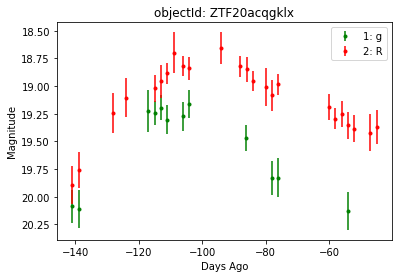

In [86]:
# make the plot
pgb.figures.plot_lightcurve(lcdf, objectId=objectId)
# this function was adapted from:
# https://github.com/ZwickyTransientFacility/ztf-avro-alert/blob/master/notebooks/Filtering_alerts.ipynb

---

### Cone Search

In [18]:
# from astroquery.vo_conesearch import conf, conesearch, vos_catalog


In [58]:
center = coord.SkyCoord(76.91, 6.02, frame='icrs', unit='deg')
radius = coord.Angle(2, unit=u.deg)

columns = ['jd', 'fid', 'magpsf', 'sigmapsf']
# 'objectId' and 'candid' will be included automatically
# options are in the 'candidates' table
# pgb.bigquery.get_table_info('candidates')
dry_run = False

# we'll restrict to a handful of objects to reduce runtime, but this is optional
objectIds = ['ZTF18aczuwfe', 'ZTF18aczvqcr', 'ZTF20acqgklx', 'ZTF18acexdlh']

To perform a cone search, we query for object histories and then check whether they are within the cone. 
`pgb.bigquery.cone_search()` is a convenience wrapper for this.
It's options are demonstrated below. 


In [ ]:
# Option 1: Get a single df of all objects in the cone

objects_in_cone = pgb.bigquery.cone_search(center, radius, columns, 
                                           objectIds=objectIds, 
                                           dry_run=dry_run
                                           )
objects_in_cone.sample(5)

In [64]:
# Option 2: Get a single json string of all objects in the cone
format = 'json'

objects_in_cone = pgb.bigquery.cone_search(center, radius, columns, 
                                           objectIds=objectIds, 
                                           format=format, 
                                           dry_run=dry_run
                                           )
objects_in_cone

'{"objectId":{"0":"ZTF20acqgklx","1":"ZTF20acqgklx","2":"ZTF20acqgklx","3":"ZTF20acqgklx","4":"ZTF20acqgklx","5":"ZTF20acqgklx","6":"ZTF20acqgklx","7":"ZTF20acqgklx","8":"ZTF20acqgklx","9":"ZTF20acqgklx","10":"ZTF20acqgklx","11":"ZTF20acqgklx","12":"ZTF20acqgklx","13":"ZTF20acqgklx","14":"ZTF20acqgklx","15":"ZTF20acqgklx","16":"ZTF20acqgklx","17":"ZTF20acqgklx","18":"ZTF20acqgklx","19":"ZTF20acqgklx","20":"ZTF20acqgklx","21":"ZTF20acqgklx","22":"ZTF20acqgklx","23":"ZTF20acqgklx","24":"ZTF20acqgklx","25":"ZTF20acqgklx","26":"ZTF20acqgklx","27":"ZTF20acqgklx","28":"ZTF20acqgklx","29":"ZTF20acqgklx","30":"ZTF20acqgklx","31":"ZTF20acqgklx","32":"ZTF20acqgklx","33":"ZTF20acqgklx","34":"ZTF20acqgklx","35":"ZTF20acqgklx","36":"ZTF18aczuwfe","37":"ZTF18aczuwfe","38":"ZTF18aczuwfe","39":"ZTF18aczuwfe","40":"ZTF18aczuwfe","41":"ZTF18aczuwfe","42":"ZTF18aczuwfe","43":"ZTF18aczuwfe","44":"ZTF18aczuwfe","45":"ZTF18aczuwfe","46":"ZTF18aczuwfe","47":"ZTF18aczuwfe","48":"ZTF18aczuwfe","49":"ZTF18aczuw

In [65]:
# Option 3: Get a generator that yields individual dfs of individual objects in the cone
iterator = True

objects_in_cone = pgb.bigquery.cone_search(center, radius, columns, 
                                           objectIds=objectIds, 
                                           iterator=iterator, 
                                           dry_run=dry_run
                                           )
for obj in objects_in_cone:
    print(f'objectId: {obj.objectId}')  # objectId in metadata
    print(obj.head())

objectId: ZTF18aczuwfe
                          dec         ra  ...     magpsf  sigmapsf
candid                                    ...                     
1440303993415015003  5.387416  77.496741  ...  19.807590  0.159926
1440322513415015004  5.387412  77.496732  ...  19.819330  0.127621
1442328323415015002  5.387380  77.496730  ...  19.782700  0.172808
1444285643415015001  5.387246  77.496826  ...  19.927372  0.209740
1449226053415015000  5.387483  77.496774  ...  19.965925  0.170471

[5 rows x 6 columns]
objectId: ZTF20acqgklx
                          dec         ra  ...     magpsf  sigmapsf
candid                                    ...                     
1414351235215015023  7.760149  76.633736  ...  19.898302  0.171336
1414365935215015038  7.760131  76.633646  ...  20.088041  0.152007
1416400905215015017  7.760113  76.633719  ...  19.761951  0.163898
1416427635215015028  7.760097  76.633691  ...  20.111706  0.172291
1427289515215015014  7.760118  76.633629  ...  19.247551  0.1

In [ ]:
# Get a generator that yields a json string of individual objects in the cone
format = 'json'
iterator = True

objects_in_cone = pgb.bigquery.cone_search(center, radius, columns, 
                                           objectIds=objectIds, 
                                           format=format, 
                                           iterator=iterator, 
                                           dry_run=dry_run
                                           )
for obj in objects_in_cone:
    print(obj)

---

### Using `google.cloud.bigquery` directly

The previous sections demonstrated convenience wrappers for querying with `google.cloud.bigquery`. Here we demonstrate using these tools directly with some basic examples. View `pgb_utils` source code for more examples.

Links to more information:
- [Query syntax in Standard SQL](https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax)
- [`google.cloud.bigquery` docs](https://googleapis.dev/python/bigquery/latest/index.html)

Query setup:

In [66]:
# Create a BigQuery Client to handle the connections
bq_client = bigquery.Client(project=my_project_id)

In [70]:
# Write the standard SQL query statement

# pgb.bigquery.get_dataset_table_names()  # view available tables
# pgb.bigquery.get_table_info('<table>')  # view available column names

# construct the full table name
table = 'salt2'
dataset = 'ztf_alerts'
full_table_name = f'{pgb_project_id}.{dataset}.{table}'

# construct the query
query = (
    f'SELECT objectId, candid, t0, x0, x1, c, chisq, ndof '
    f'FROM `{full_table_name}` '
    f'WHERE ndof>0 and chisq/ndof<2 '
)

# note: if you want to query object histories you can get the
# query statement using `pgb.bigquery.object_history_sql_statement()`

In [71]:
# Let's create a function to execute a "dry run"
# and tell us how much data will be processed.
# This is essentially `pgb.bigquery.dry_run()`
def dry_run(query):
    job_config = bigquery.QueryJobConfig(dry_run=True, use_query_cache=False)
    query_job = bq_client.query(query, job_config=job_config)
    nbytes, TB = query_job.total_bytes_processed, 1e12
    print(f'\nQuery statement:')
    print(f'\n"{query}"\n')
    print(f'will process {nbytes} bytes of data.')
    print(f'({nbytes/TB*100:.3}% of your 1 TB Free Tier monthly allotment.)')

In [72]:
# Find out how much data will be processed
dry_run(query)


Query statement:

"SELECT objectId, candid, t0, x0, x1, c, chisq, ndof FROM `ardent-cycling-243415.ztf_alerts.salt2` WHERE ndof>0 and chisq/ndof<2 "

will process 9050090 bytes of data.
(0.000905% of your 1 TB free monthly allotment.)


Query:

In [74]:
# Make the API request
query_job = bq_client.query(query)
# Beware: the results may contain duplicate entries

Format and view results:

t0        x0  ...      chisq  ndof
objectId     candid                                       ...                 
ZTF17aaaabel 1444159835815015011  59180.000000  0.000222  ...   4.381339     3
             1472158805815015024  59208.814644  0.000240  ...  10.093228     6
ZTF17aaaaegy 1444221433815015006  59182.431055  0.000363  ...   5.854417     3
ZTF17aaaagah 1416296776015015004  59145.987063  0.000495  ...  10.179439     6
ZTF17aaaajpm 1425093023515015003  59157.510063  0.000314  ...  22.511310    13

[5 rows x 6 columns]

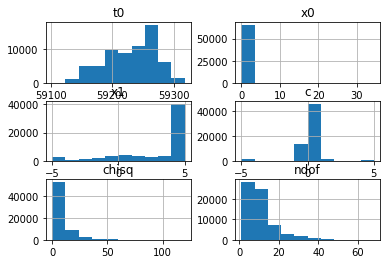

In [80]:
# Option 1: dump results to a pandas.DataFrame
df = query_job.to_dataframe()

# some things you might want to do with it
df = df.drop_duplicates()
df = df.set_index(['objectId','candid']).sort_index()

df.hist()
df.head()

In [83]:
# Option 2: parse results row by row
for r, row in enumerate(query_job):
    
    # row values can be accessed by field name or index
    print(f"objectId={row[0]}, t0={row['t0']}")
    
    if r>5: break

objectId=ZTF20acvamqy, t0=59188.41745606396
objectId=ZTF20acusylb, t0=59192.986445123555
objectId=ZTF18acaopar, t0=59177.99999987393
objectId=ZTF18abvfafa, t0=59173.38747656424
objectId=ZTF19aaagqok, t0=59173.999998093954
objectId=ZTF19aaagqok, t0=59173.99999999364
objectId=ZTF20acusylb, t0=59193.163268315955


---

## 2b) Command-line tool `bq`

All commands in this section are executed using the `run` function we created earlier to run commands on the command-line.

`bq`'s default dialect is legacy SQL. Here we use standard SQL by passing `--use_legacy_sql=false`.
<!-- (see [change to standard SQL](https://cloud.google.com/bigquery/docs/reference/standard-sql/enabling-standard-sql#changing_from_the_default_dialect)) -->

Links to more information:
- [Quickstart using the bq command-line tool](https://cloud.google.com/bigquery/docs/quickstarts/quickstart-command-line)
- [Reference of all `bq` commands and flags](https://cloud.google.com/bigquery/docs/reference/bq-cli-reference)
- [Query syntax in Standard SQL](https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax)

In [ ]:
# Get help
run('bq help query')

In [ ]:
# view the schema of a table
run('bq show --schema --format=prettyjson ardent-cycling-243415:ztf_alerts.candidates')
# run('bq show --schema --format=prettyjson ardent-cycling-243415:ztf_alerts.alerts')

# Note: The first time you make a call with `bq` you will ask you to 
# initialize a .bigqueryrc configuration file. Follow the directions.

In [91]:
# Query: dry run

# first we do a dry_run by including the flag --dry_run
bq_query = """bq query \
--dry_run \
--use_legacy_sql=false \
'SELECT 
    objectId, candid, t0, x0, x1, c, chisq, ndof
FROM 
    `ardent-cycling-243415.ztf_alerts.salt2`
WHERE 
    ndof>0 and chisq/ndof<2
LIMIT
    10'
"""

run(bq_query)
# Note: to execute this directly in the command-line, enter everything 
# contained within the triple quotes.

>> bq query --dry_run --use_legacy_sql=false 'SELECT 
    objectId, candid, t0, x0, x1, c, chisq, ndof
FROM 
    `ardent-cycling-243415.ztf_alerts.salt2`
WHERE 
    ndof>0 and chisq/ndof<2
LIMIT
    10'

Query successfully validated. Assuming the tables are not modified, running this query will process 9050090 bytes of data.



In [ ]:
# Query

bq_query = """bq query \
--use_legacy_sql=false \
'SELECT 
    objectId, candid, t0, x0, x1, c, chisq, ndof
FROM 
    `ardent-cycling-243415.ztf_alerts.salt2`
WHERE 
    ndof>0 and chisq/ndof<2
LIMIT
    10'
"""

run(bq_query)

---

# 3) File Storage & Cloud Storage

I plan to rename the files and the bucket before the workshop as follows:
- old bucket: `ardent-cycling-243415_ztf_alert_avro_bucket`
- new bucket: `ardent-cycling-243415_ztf_alert_avros`
- old files: `{ztf_topic}_{kafka_timestamp}.avro`
- new files: `{objectId}.{candid}.{ztf_topic}.avro`
---

- Pricing
    - [Cloud Storage pricing](https://cloud.google.com/storage/pricing)
        - [Free Tier](https://cloud.google.com/storage/pricing#cloud-storage-always-free) includes >=5000 operations per month, but is limited to US regions(*). Standard operations are $0.004-$0.05 per 10,000 operations (depending on type).



## 3a) Python

- [Python Client documentation](https://googleapis.dev/python/storage/latest/client.html)

### Download files

Download alerts from a given night

In [ ]:
night = 20210404  # yyyymmdd. ENTER YOUR DATE
bucket_name = f'{pgb_project_id}_ztf_alert_avro_bucket'

# Create a client and request a list of files
storage_client = storage.Client(project=my_project_id)
bucket = storage_client.get_bucket(bucket_name)
blobs = bucket.list_blobs(prefix=f'ztf_{night}', delimiter='/')

In [ ]:
# download the files
for b, blob in enumerate(blobs):
    local_path = f'{colabpath_noesc}/{blob.name}'
    blob.download_to_filename(local_path)

    if b>10:
        break

### Plot cutouts and lightcurves

Open a file
(see the previous section to download files)

In [96]:
paths = Path(colabpath_noesc).glob('*.avro')
for path in paths:
    with open(path, 'rb') as fin:
        alert_list = [r for r in fastavro.reader(fin)]
    break
alert_dict = alert_list[0]  # extract the single alert packet

print(alert_dict.keys())

dict_keys(['schemavsn', 'publisher', 'objectId', 'candid', 'candidate', 'prv_candidates', 'cutoutScience', 'cutoutTemplate', 'cutoutDifference'])


Plot cutouts

In [ ]:
pgb.figures.plot_cutouts(alert_dict)
# this function was adapted from:
# https://github.com/ZwickyTransientFacility/ztf-avro-alert/blob/master/notebooks/Filtering_alerts.ipynb

Cast to a dataframe and plot lightcurves

In [ ]:
dflc = pgb.utils.alert_dict_to_dataframe(alert_dict)
pgb.figures.plot_lightcurve(dflc)
# both functions were adapted from:
# https://github.com/ZwickyTransientFacility/ztf-avro-alert/blob/master/notebooks/Filtering_alerts.ipynb


Plot everything together

In [ ]:
pgb.figures.plot_lightcurve_cutouts(alert_dict)


## 3b) Command-line tool `gsutil`

- [Quickstart: Using the gsutil tool](https://cloud.google.com/storage/docs/quickstart-gsutil)
- [`gsutil cp` - Copy files and objects](https://cloud.google.com/storage/docs/gsutil/commands/cp)

In [ ]:
# Get help
# run('gsutil help')
run('gsutil help cp')

Download a single file

In [101]:
run(f'gsutil cp gs://ardent-cycling-243415_ztf_alert_avro_bucket/ztf_20210401_programid1_1617259046498.avro {colabpath}/.')

>> gsutil cp gs://ardent-cycling-243415_ztf_alert_avro_bucket/ztf_20210401_programid1_1617259046498.avro /content/drive/MyDrive/Colab\ Notebooks/PGB/.
Copying gs://ardent-cycling-243415_ztf_alert_avro_bucket/ztf_20210401_programid1_1617259046498.avro...
/ [1 files][ 67.9 KiB/ 67.9 KiB]                                                
Operation completed over 1 objects/67.9 KiB.                                     



---

# 4) Message streams & Pub/Sub

__This section is not ready for review.__ 

- Python
  - unpack into dict

  Links to more information:
  - [Quickstart using the gcloud command-line tool](https://cloud.google.com/pubsub/docs/quickstart-cli)

---

# 5) Extra: Apache Beam data pipelines with BigQuery and Pub/Sub

[Apache Beam](https://beam.apache.org/) is an SDK that facilitates writing and executing data pipelines.
The same pipeline can be attached to different sources (e.g., BigQuery and Pub/Sub) and run in batch or streaming mode.
In this tutorial, we will demonstrate these pipelines and the
`pgb_utils` tools that facilitate Beam access to our databases and streams.

Links to more information:
- [Apache Beam Programming Guide](https://beam.apache.org/documentation/programming-guide/) (very useful!)
- [Colab Snippets: Apache Beam](https://colab.research.google.com/github/apache/beam/blob/master/examples/notebooks/get-started/try-apache-beam-py.ipynb)

Note: We will execute pipelines directly in the notebook, but the same pipelines can be executed on a local machine or various distributed systems using different "runners". 
For example, see 
[Apache Flink](https://beam.apache.org/documentation/runners/flink/), 
[Apache Spark](https://beam.apache.org/documentation/runners/spark/), 
[Google Dataflow](https://beam.apache.org/documentation/runners/dataflow/), and
[DirectRunner](https://beam.apache.org/documentation/runners/direct/) (the last being the default, which we use below).
The user sets a few configurations and the runner manages the pipeline execution and the resources (e.g., VM's) and environments needed to run it.

---

## 5a) A demo example

To demonstrate the basic steps of an Apache Beam pipeline, we'll create one that counts the words in Shakespear's King Lear.
Adapted from [this notebook](https://colab.research.google.com/github/apache/beam/blob/master/examples/notebooks/get-started/try-apache-beam-py.ipynb).

In [111]:
import re

Setup: create some paths and download a copy of King Lear

In [126]:
dkinglear = f'{colabpath}/kinglear'
dkinglear_noesc = f'{colabpath_noesc}/kinglear'
run(f'mkdir -p {dkinglear}')
run(f'mkdir -p {dkinglear}/outputs')

# download the text file
run(f'gsutil cp gs://dataflow-samples/shakespeare/kinglear.txt {dkinglear}/')

>> mkdir -p /content/drive/MyDrive/Colab\ Notebooks/PGB/kinglear

>> mkdir -p /content/drive/MyDrive/Colab\ Notebooks/PGB/kinglear/outputs

>> gsutil cp gs://dataflow-samples/shakespeare/kinglear.txt /content/drive/MyDrive/Colab\ Notebooks/PGB/kinglear/
Copying gs://dataflow-samples/shakespeare/kinglear.txt...
/ [1 files][153.6 KiB/153.6 KiB]                                                
Operation completed over 1 objects/153.6 KiB.                                    



Define and run the pipeline. 

Note 1: This example demonstrates the use of several different Apache Beam functions (e.g., `beam.Map()`, `beam.Filter()`) to apply user-defined functions in various ways. 
This will give you an idea about what it possible. 
However, don't worry about the details of this example.
Below we will demonstrate the 2 most useful `beam` transforms for applying user-defined functions to our data sources, and provide templates for using them. 
In addition, we provide convenience functions in `pgb_utils.beam` and templates for reading from our data sources.

Note 2: Some [operators are overloaded](https://stackoverflow.com/questions/43796046/explain-apache-beam-python-syntax):
- `|` means `apply`
- `>>` allows you to name the step with the preceeding string. It is optional. We use it here to improve readability. Various UIs like Dataflow use it in their displays.

In [137]:
input_pattern = f'{dkinglear_noesc}/*'
outputs_prefix = f'{dkinglear_noesc}/outputs/part'

# 1. Instantiate a pipeline object
with beam.Pipeline() as pipeline:
  (
    # 2. Start the pipeline by piping it a "read" function
      pipeline
      | 'Read lines' >> beam.io.ReadFromText(input_pattern)

    # 3. OPERATE ON THE INPUT DATA.
    #    These `lambda` functions are simple examples of USER-DEFINED FUNCTIONS
    #    applied to the output of the previous transformation in various ways.
      | 'Find words' >> beam.FlatMap(lambda line: re.findall(r"[a-zA-Z']+", line))
      | 'Pair words with 1' >> beam.Map(lambda word: (word, 1))
      | 'Group and sum' >> beam.CombinePerKey(sum)
      | 'Filter for counts < 10' >> beam.Filter(lambda x: x[1]<10)

    # 4. Format and output the results
      | 'Format results' >> beam.Map(lambda word_count: str(word_count))
      | 'Write results' >> beam.io.WriteToText(outputs_prefix)
  )

Look at the first 20 results. (Beware, there are no ordering guarantees.)

In [139]:
outputs_prefix_esc = f'{dkinglear}/outputs/part'
run('head -n 20 {}-00000-of-*'.format(outputs_prefix_esc))

>> head -n 20 /content/drive/MyDrive/Colab\ Notebooks/PGB/kinglear/outputs/part-00000-of-*
('DRAMATIS', 1)
('PERSONAE', 1)
('Britain', 2)
('DUKE', 3)
('BURGUNDY', 8)
('EARL', 2)
('bastard', 7)
('CURAN', 6)
('courtier', 1)
('tenant', 3)
('steward', 2)
('employed', 1)
('attendant', 1)
('Herald', 6)
('Servants', 9)
('First', 7)
('Second', 4)
('Third', 4)
('Knights', 2)
("Lear's", 4)



Final note: Here we have simply chained the pipeline steps together, but the output of each transformation is an immutable collection that we can assign to a variable and pipe in to multiple transforms, as in this code fragment:

```python
      king_lear = (
          pipeline | 'Read lines' >> 
          beam.io.ReadFromText(input_pattern)
      )
      word_counts = (
          king_lear | 'Count words' >>
          <... count words ...>
      )
      sentence_counts = (
          king_lear | 'Count sentences' >>
          <... count sentences ...>
      )
```

## 5b) Query lightcurves and run a pipeline on the results



First we will define the functions we wish to use to process the lightcurves. 
We will demonstrate two kinds of transformations that should cover most use cases:
- filters
- generic processing

We will filter for likely solar system objects and then calculate their mean magnitudes.

In [142]:
# Define some functions/classes to process our data.
# The structure of these will be discussed later.

# Filter for likely solar system objects
def nearby_ssobject(lcdf):
    """Filter that keeps only objects that are within 5" of a known 
    solar system object. 
    """
    ssdistnr = lcdf['ssdistnr'].mean()
    ssobject_is_near = (ssdistnr > 0) and (ssdistnr < 5)
    return ssobject_is_near


# Calculate the mean magnitude, per passband
class calc_mean_mags(beam.DoFn):
    """Class that wraps our processing function which calculates 
    mean magnitudes per passband ("fid" is filter ID).
    """
    def process(self, lcdf):
        meanmags = lcdf[['fid','magpsf']].groupby('fid').mean()

        # We will write this to a file, so let's format it appropriately.
        # One line per item in the list will be written.
        output = [f"{lcdf.objectId},{fid},{row['magpsf']}" for fid, row in meanmags.iterrows()]

        return output

In [143]:
# Set pipeline configs

# Create a SQL query statement to retrieve some lightcurve info.
# This query defines the data that will be input to the pipeline.
columns = ['jd', 'fid', 'magpsf', 'sigmapsf', 'ssdistnr']
limit = 2000
query = pgb.bigquery.object_history_sql_statement(columns, limit=limit)  # str

# some keyword args for our pipeline's "read" (input) function
read_args = {
    'query': query, 
    'project': pgb_project_id,  
    'use_standard_sql': True, 
    'gcs_location': 'gs://ardent-cycling-243415_dataflow-test',
        # used as temporary storage for the query results
    # 'validate': True
}

# path to write the results
outputs_prefix = f'{colabpath}/outputs/meanmags'
beam_outputs_prefix = f'{colabpath_noesc}/outputs/meanmags'

In [144]:
# Run a batch pipeline based on our query statement

with beam.Pipeline() as pipeline:
    (
        pipeline
        # read lightcurves into the pipeline
        | 'Read BigQuery' >> beam.io.ReadFromBigQuery(**read_args)
        # extract the lightcurves into a DataFrame
        | 'Extract Lightcurve df' >> beam.ParDo(pgb.beam.ExtractHistoryDf())
        # filter, keep alerts likely to be a solar system object
        | 'nearby ssobject' >> beam.Filter(nearby_ssobject)
        # do some processing, calculate mean magnitudes per band
        | 'calc mean mags' >> beam.ParDo(calc_mean_mags())
        # save the results to a text file
        | 'Write results' >> beam.io.WriteToText(beam_outputs_prefix)
    )

/usr/local/lib/python3.7/dist-packages/apache_beam/io/gcp/bigquery.py:1881: BeamDeprecationWarning: options is deprecated since First stable release. References to <pipeline>.options will not be supported
  temp_location = pcoll.pipeline.options.view_as(


In [145]:
# Sample the first 20 results, remember there are no ordering guarantees.
run('head -n 20 {}-00000-of-*'.format(outputs_prefix))

>> head -n 20 /content/drive/MyDrive/Colab\ Notebooks/PGB/outputs/meanmags-00000-of-*
ZTF20acpkjly,1,18.692398071289062
ZTF20acpnkoy,1,20.167924880981445
ZTF20acpkjvo,1,19.18564796447754
ZTF20acpmoku,1,19.961729049682617
ZTF20acpixfc,1,19.34815788269043
ZTF20acpnkqk,1,20.365970611572266
ZTF20acpkjnx,1,19.840303421020508
ZTF20acpkvml,2,19.726783752441406
ZTF20acpkros,2,19.76658821105957
ZTF20acphrrt,2,20.318077087402344
ZTF20acplinw,2,19.12528419494629
ZTF20acplwue,2,19.851957321166992
ZTF20acpkrmm,2,19.59676170349121
ZTF20acpkwla,2,20.25066375732422
ZTF20acpkzlv,2,20.338178634643555
ZTF20acplbli,2,19.559131622314453



In [ ]:
# Functions and classes for the user to experiment with.

#--- Filters
# https://beam.apache.org/documentation/transforms/python/elementwise/filter/
def my_lightcurve_filter(lcdf):
    """
    Args:
        lcdf (pd.DataFrame): a single object's lightcurve data
    Returns:
        keep_lightcurve (bool): True to keep lcdf in the pipeline, 
                                False to filter it out
    """
    # Define your keep_lightcurve bool here
    # for example, we can simply keep everything with an average magpsf > 19
    avg_mag = lcdf['magpsf'].mean()
    keep_lightcurve = avg_mag > 19

    return keep_lightcurve

#--- Functions for processing data
# [provide a link]
class my_alert_function(beam.DoFn):
    def process(self, alertDict):

        # Do your processing here
        # for example, we can simply extract the object and candidate ids
        oid, cid = alertDict['objectId'], alertDict['candid']
        ids = {'objectId': oid, 'candid': cid}

        # Return your output as a list; each element in the list must be
        # of the same type, and will be processed individually by the next 
        # stage in the pipeline.
        return [ids]

---
__The rest of this section is not ready for review.__

In [ ]:
# give them a pipeline that runs the functions in the previous cell

Alert Pipelines

In [ ]:
# Alert pipelines

# example filter for likely solar system objects

def nearby_ssobject(alert):
    candidate = alert['candidate']
    ssobject_is_near = (candidate['ssdistnr'] > 0) and (candidate['ssdistnr'] < 5)
    return ssobject_is_near

# Functions and classes for the user to experiment with.

#--- Filters
# https://beam.apache.org/documentation/transforms/python/elementwise/filter/

# write your own filter
def my_alert_filter(alert):
    """
    Args:
        alert (dict): a single alert
    Returns:
        keep_alert (bool): True to keep the alert, False to filter it out
    """

class my_alert_function(beam.DoFn):
    def process(self, alertDict):

        # Process the alert however you want
        # here we simply extract the object and candidate ids
        oid, cid = alertDict['objectId'], alertDict['candid']
        ids = {'objectId': oid, 'candid': cid}

        # Return your output in a list
        return [ids]


In [ ]:
from apache_beam.options.pipeline_options import PipelineOptions

pipeline_options = PipelineOptions(streaming=True)

In [ ]:
topic = f'projects/{pgb_project_id}/topics/ztf_alert_data'

with beam.Pipeline(options=pipeline_options) as pipeline:
    (
        pipeline
        # read Pub/Sub messages (bytes) into the pipeline
        | 'ReadFromPubSub' >> beam.io.ReadFromPubSub(topic=topic)
        # extract the alert bytes into a dict
        | 'ExtractAlertDict' >> beam.ParDo(pgb.beam.ExtractAlertDict())
        # filter, keep alerts likely to be a solar system object
        | 'nearby_ssobject' >> beam.Filter(nearby_ssobject)
        # do some processing
        | 'my_function' >> beam.ParDo(my_alert_function())
    )

In [ ]:
# Run a Streaming Beam pipeline

topic = 'ztf_alert_data-tjr'

with beam.Pipeline(options=pipeline_options) as pipeline:
    (
        pipeline
        # read Pub/Sub messages (bytes) into the pipeline
        | 'ReadFromPubSub' >> beam.io.ReadFromPubSub(topic=topic)
        # extract the alert bytes into a dict
        | 'ExtractAlertDict' >> beam.ParDo(extractAlertDict()))
        # filter, keep alerts likely to be a solar system object
        | 'nearby_ssobject' >> beam.Filter(nearby_ssobject)
        # do some processing
        | 'my_function' >> beam.ParDo(my_function())
    )

In [ ]:
# Sample the first 20 results, remember there are no ordering guarantees.
run('head -n 20 {}-00000-of-*'.format(outputs_prefix))

---

In [ ]:
#--- Minimal word count (example)
import re

# download some King Lear data
run(f'mkdir -p {colabpath}/data')
run(f'gsutil cp gs://dataflow-samples/shakespeare/kinglear.txt {colabpath}/data/')

# configs
inputs_pattern = f'{colabpath}/data/*'
outputs_prefix = f'{colabpath}/outputs/fromcolab3'

# Running locally in the DirectRunner.
with beam.Pipeline() as pipeline:
  (
      pipeline
      | 'Read lines' >> beam.io.ReadFromText(inputs_pattern)
      | 'Find words' >> beam.FlatMap(lambda line: re.findall(r"[a-zA-Z']+", line))
      | 'Pair words with 1' >> beam.Map(lambda word: (word, 1))
      | 'Group and sum' >> beam.CombinePerKey(sum)
      | 'Format results' >> beam.Map(lambda word_count: str(word_count))
      | 'Write results' >> beam.io.WriteToText(outputs_prefix)
  )

# Sample the first 20 results, remember there are no ordering guarantees.
run('head -n 20 {}-00000-of-*'.format(outputs_prefix))